# Utils

In [533]:
!pip install shap
!pip install lightfm
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [534]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [535]:
import shap
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import ndcg_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from lightfm.data import Dataset
from lightfm import LightFM

from catboost import CatBoostClassifier

from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)


# metrics NDCG@k, MAP@K

In [536]:
def average_prec_k(y_true, y_pred, k=0):

    if k != 0:
        y_pred = y_pred[:k]
    else:
        k=1

    correct_predictions = 0
    running_sum = 0

    for i, yp_item in enumerate(y_pred, 1):
        if yp_item in y_true:
            correct_predictions += 1
        running_sum += correct_predictions/i

    return running_sum/min(len(y_true), k)

#1. Data Preparation

In [537]:
inter = pd.read_parquet('/content/drive/MyDrive/RecSys/interactions.parquet')
movies = pd.read_parquet('/content/drive/MyDrive/RecSys/movies_metdata.parquet')

In [538]:
inter.head()

,year,month,day,user_id,movie_id,watch_duration_minutes
0,2022,10,1,58073,a6889772-f1f4-45bc-9663-85b46fc8499d,4.800
1,2022,10,1,63698,c829f262-ddf1-46b7-a896-a7efc205028c,15.000
2,2022,10,1,66655,91f9d892-a508-4962-91e9-abacd93e0830,51.917
3,2022,10,1,66655,58b805e1-a65c-49f4-b302-865cacaaed8a,22.317
4,2022,10,1,67981,dbc44c07-46e2-4fb0-b57c-8b5172421683,117.000


In [539]:
len(inter)

1800000

In [540]:
count_inter = inter.groupby('user_id').count()['movie_id']
count_inter.describe()

count   127060.000
mean        14.167
std         27.019
min          1.000
25%          2.000
50%          5.000
75%         15.000
max       1194.000
Name: movie_id, dtype: float64

In [541]:
# almost half the users have very few interactions, very 'cold-start' like problem
len(count_inter[count_inter < 5])

61275

In [542]:
movies.head()

,movie_id,title,entity_type,genres,actors,director,country,release_world,age_rating,duration
0,395a85a9-2200-4a29-a878-97753c471f79,Свиридовы,Серия,"[""Мелодрамы""]","[""Андрей Мерзликин"",""Алексей Горбунов"",""Елена ...","[""Эльдар Салаватов""]","[""Россия""]",2013-12-15,16.000,49.000
1,6fd5f7b5-8278-4d9a-b03a-54a8bf0bc7c8,Охотники за головами,Серия,"[""Детективы"",""Драмы""]","[""Филипп Янковский"",""Елизавета Боярская"",""Конс...","[""Иван Шурховецкий""]","[""Россия""]",2014-03-03,16.000,48.000
2,b239c99e-d1ea-4c01-b83f-6b5469a6b70a,Молодое поколение,Серия,"[""Комедии"",""Мелодрамы""]","[""Юн Пак"",""Пак Ын-бин"",""Хан Е-ри"",""Ким Мин-сок...","[""Ким Сан-хо"",""Ли Тхэ-гон""]","[""Корея Южная""]",2016-07-22,16.000,65.000
3,9dc02ab1-7bd2-45c2-9b8c-ae29e9813ccf,Художницы,Серия,"[""Документальное""]","[""Катарина Лопаткина""]","[""Школа Masters""]","[""Россия""]",2019-02-01,18.000,27.000
4,54b3b5fe-7d2a-47ba-9a1d-4dc3a3a8ff96,Веселая Астрология,Серия,"[""Мультфильмы""]","[""Стивен Боунс"",""Хашир Хайзал Хаилми"",""Логандр...","[""Кен Фунг""]","[""Малайзия""]",2017-10-01,6.000,3.000


In [543]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226260 entries, 0 to 252238
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   movie_id       226260 non-null  object 
 1   title          226259 non-null  object 
 2   entity_type    226260 non-null  object 
 3   genres         206571 non-null  object 
 4   actors         206575 non-null  object 
 5   director       206766 non-null  object 
 6   country        206273 non-null  object 
 7   release_world  197710 non-null  object 
 8   age_rating     206220 non-null  float64
 9   duration       192624 non-null  float64
dtypes: float64(2), object(8)
memory usage: 19.0+ MB


## 1.1 Work with movies data 

In [544]:
df = movies.join(inter.set_index('movie_id'), on='movie_id', how='left')

In [545]:
len(df[df['duration'] > df['watch_duration_minutes']])

1365926

In [546]:
len(df[df['duration'].isna()])

370578

In [547]:
df['watch_duration_minutes'] = df.apply(lambda x: x['watch_duration_minutes']
                                        if (x['watch_duration_minutes'] < x['duration']
                                        or pd.isna(x['duration']))
                                        else x['duration'], axis=1)

In [548]:
len(df[df['duration'] > df['watch_duration_minutes']])

1365926

In [549]:
avg_watch = df.groupby('movie_id')['watch_duration_minutes'].mean().to_dict()
median_watch = df.groupby('movie_id')['watch_duration_minutes'].median().to_dict()
popularity = df.groupby('movie_id')['user_id'].nunique().to_dict()
rewatches = (df.groupby('movie_id')['user_id'].count() / df.groupby('movie_id')['user_id'].nunique()).to_dict()

In [550]:
check_avg_const = movies[movies['duration'].notna()]
check_avg_const['avg_watch'] = check_avg_const['movie_id'].apply(lambda x: avg_watch[x])
check_avg_const = check_avg_const[check_avg_const['avg_watch'].notna()]

(check_avg_const['avg_watch']/check_avg_const['duration']).describe()

count   192614.000
mean         0.957
std          0.159
min          0.000
25%          1.000
50%          1.000
75%          1.000
max          1.000
dtype: float64

In [551]:
movies['duration'] = movies['duration'].fillna(0)
duration_dict = movies.set_index('movie_id')['duration'].to_dict()

movies['avg_watch'] = movies['movie_id'].apply(lambda x: avg_watch[x] if pd.notna(avg_watch[x]) else duration_dict[x]*0.96)
movies['median_watch'] = movies['movie_id'].apply(lambda x: median_watch[x] if pd.notna(median_watch[x]) else duration_dict[x])
movies['popularity'] = movies['movie_id'].apply(lambda x: popularity[x] if pd.notna(popularity[x]) else 0)
movies['rewatches'] = movies['movie_id'].apply(lambda x: rewatches[x] if pd.notna(rewatches[x]) else 0)

In [552]:
def f(dur, avg):
    if dur == 0:
        return avg/0.96
    else:
        return dur

movies['duration_est'] = movies.apply(lambda x: f(x['duration'], x['avg_watch']), axis=1)

In [553]:
movies['avg_watch'] = movies['avg_watch'] * movies['popularity'].apply(lambda x: min(1, x))
movies['median_watch'] = movies['median_watch'] * movies['popularity'].apply(lambda x: min(1, x))
movies['watched_ratio'] = (movies['avg_watch']/movies['duration_est']).fillna(0)

In [554]:
movies['age_rating'] = movies['age_rating'].fillna(movies['age_rating'].median())
movies['release_world'] = movies['release_world'].fillna('0-0-0')
movies = movies.fillna('["UNKNOWN"]')

In [555]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226260 entries, 0 to 252238
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   movie_id       226260 non-null  object 
 1   title          226260 non-null  object 
 2   entity_type    226260 non-null  object 
 3   genres         226260 non-null  object 
 4   actors         226260 non-null  object 
 5   director       226260 non-null  object 
 6   country        226260 non-null  object 
 7   release_world  226260 non-null  object 
 8   age_rating     226260 non-null  float64
 9   duration       226260 non-null  float64
 10  avg_watch      226260 non-null  float64
 11  median_watch   226260 non-null  float64
 12  popularity     226260 non-null  int64  
 13  rewatches      226260 non-null  float64
 14  duration_est   226260 non-null  float64
 15  watched_ratio  226260 non-null  float64
dtypes: float64(7), int64(1), object(8)
memory usage: 29.3+ MB


In [556]:
movies['main_genre'] = movies['genres'].apply(lambda x: x.strip('[]').split(',')[0].strip('"'))
movies['main_actor'] = movies['actors'].apply(lambda x: x.strip('[]').split(',')[0].strip('"'))
movies['main_director'] = movies['director'].apply(lambda x: x.strip('[]').split(',')[0].strip('"'))
movies['main_country'] = movies['country'].apply(lambda x: x.strip('[]').split(',')[0].strip('"'))

movies['released_year'] =  movies['release_world'].apply(lambda x: x.strip('\'').split('-')[0])
movies['released_month'] =  movies['release_world'].apply(lambda x: x.strip('\'').split('-')[1])

In [557]:
clean_movies = movies.drop(columns=['genres', 'actors', 'director', 'country', 'release_world'])
clean_movies.head()

,movie_id,title,entity_type,age_rating,duration,avg_watch,median_watch,popularity,rewatches,duration_est,watched_ratio,main_genre,main_actor,main_director,main_country,released_year,released_month
0,395a85a9-2200-4a29-a878-97753c471f79,Свиридовы,Серия,16.000,49.000,0.000,0.000,0,0.000,49.000,0.000,Мелодрамы,Андрей Мерзликин,Эльдар Салаватов,Россия,2013,12
1,6fd5f7b5-8278-4d9a-b03a-54a8bf0bc7c8,Охотники за головами,Серия,16.000,48.000,0.000,0.000,0,0.000,48.000,0.000,Детективы,Филипп Янковский,Иван Шурховецкий,Россия,2014,03
2,b239c99e-d1ea-4c01-b83f-6b5469a6b70a,Молодое поколение,Серия,16.000,65.000,0.000,0.000,0,0.000,65.000,0.000,Комедии,Юн Пак,Ким Сан-хо,Корея Южная,2016,07
3,9dc02ab1-7bd2-45c2-9b8c-ae29e9813ccf,Художницы,Серия,18.000,27.000,0.000,0.000,0,0.000,27.000,0.000,Документальное,Катарина Лопаткина,Школа Masters,Россия,2019,02
4,54b3b5fe-7d2a-47ba-9a1d-4dc3a3a8ff96,Веселая Астрология,Серия,6.000,3.000,0.000,0.000,0,0.000,3.000,0.000,Мультфильмы,Стивен Боунс,Кен Фунг,Малайзия,2017,10


In [558]:
clean_movies[clean_movies['watched_ratio'] > 0]['watched_ratio'].describe()

count   18565.000
mean        0.550
std         0.279
min         0.000
25%         0.368
50%         0.528
75%         0.768
max         1.000
Name: watched_ratio, dtype: float64

## 1.2 Work with interaction data

In [559]:
# We only take interactions with films we have data about

df = clean_movies.join(inter.set_index('movie_id'), on='movie_id', how='inner')

In [560]:
actors = df.groupby('user_id')['main_actor'].agg(pd.Series.mode).to_dict()
directors = df.groupby('user_id')['main_director'].agg(pd.Series.mode).to_dict()
countries = df.groupby('user_id')['main_country'].agg(pd.Series.mode).to_dict()
genres = df.groupby('user_id')['main_genre'].agg(pd.Series.mode).to_dict()

In [561]:
df['fav_actor'] = df['user_id'].apply(lambda x: actors[x][0] if type(actors[x])==np.ndarray else actors[x])
df['fav_director'] = df['user_id'].apply(lambda x: directors[x][0] if type(directors[x])==np.ndarray else directors[x])
df['fav_country'] = df['user_id'].apply(lambda x: countries[x][0] if type(countries[x])==np.ndarray else countries[x])
df['fav_genre'] = df['user_id'].apply(lambda x: genres[x][0] if type(genres[x])==np.ndarray else genres[x])

In [562]:
df['watch_duration_minutes'] = df.apply(lambda x: x['watch_duration_minutes']
                                        if x['watch_duration_minutes'] < x['duration_est']
                                        else x['duration_est'], axis=1)

In [563]:
df['watched_ratio'] = df['watch_duration_minutes']/df['duration_est']

In [564]:
clean_inter = df[['movie_id', 'user_id', 'year', 'month', 'day', 'watch_duration_minutes', 
                  'fav_actor', 'fav_director', 'fav_country', 'fav_genre', 'watched_ratio']].reset_index(drop=True)
clean_inter.head()

,movie_id,user_id,year,month,day,watch_duration_minutes,fav_actor,fav_director,fav_country,fav_genre,watched_ratio
0,62c08db2-6757-46a1-ad48-40049d4ceb57,228019116,2022,10,20,95.117,Федор Лавров,Максим Пежемский,Россия,Комедии,0.961
1,62c08db2-6757-46a1-ad48-40049d4ceb57,228022283,2022,10,20,21.067,Уильям Моусли,Кристофер Хаттон,Великобритания,Триллеры,0.213
2,62c08db2-6757-46a1-ad48-40049d4ceb57,219131777,2022,10,20,92.533,Владимир Стеклов,Ирина Гобозашвили,США,Приключения,0.935
3,62c08db2-6757-46a1-ad48-40049d4ceb57,238461020,2022,10,20,12.467,Игорь Савочкин,Владимир Котт,Россия,Приключения,0.126
4,62c08db2-6757-46a1-ad48-40049d4ceb57,195480,2022,10,20,96.567,Ку,Джастин Прайс,США,Комедии,0.975


In [565]:
clean_inter[clean_inter['watched_ratio'] > 0]['watched_ratio'].describe()

count   1782240.000
mean          0.559
std           0.384
min           0.000
25%           0.161
50%           0.596
75%           0.956
max           1.000
Name: watched_ratio, dtype: float64

In [566]:
# maybe we should use only the movies people liked

good_inter = clean_inter.loc[clean_inter['watched_ratio'] > 0.5].reset_index(drop = True)
print(len(clean_inter), len(good_inter), len(good_inter)/len(clean_inter))

1782240 971102 0.5448772331448065


## 1.3 Create user data

In [567]:
users_data = clean_inter.drop(columns=['movie_id', 'year', 'month', 'day', 'watch_duration_minutes', 'watched_ratio'])
users_data = users_data.drop_duplicates()
users_data

,user_id,fav_actor,fav_director,fav_country,fav_genre
0,228019116,Федор Лавров,Максим Пежемский,Россия,Комедии
1,228022283,Уильям Моусли,Кристофер Хаттон,Великобритания,Триллеры
2,219131777,Владимир Стеклов,Ирина Гобозашвили,США,Приключения
3,238461020,Игорь Савочкин,Владимир Котт,Россия,Приключения
4,195480,Ку,Джастин Прайс,США,Комедии
...,...,...,...,...,...
1782099,89781575,Сигурни Уивер,Хуан Антонио Байона,США,Фантастика
1782132,238566168,Виктория Бакунова,Сергей Нерсесян,Россия,Лекции
1782134,23752442,Виктория Бакунова,Сергей Нерсесян,Россия,Лекции
1782179,228029514,Вячеслав Белостоцкий,Motify,Россия,Фитнес


## 1.4 Split train and test

In [604]:
interactions_filtered = clean_inter

date = []
for index, row in interactions_filtered.iterrows():
    date.append(pd.Timestamp(year=row['year'],
             month=row['month'],
             day= row['day']))
    
interactions_filtered['last_watch_dt'] = pd.Series(date)
interactions_filtered['last_watch_dt'] = pd.to_datetime(interactions_filtered['last_watch_dt'])

In [605]:
# set dates params for filter
MAX_DATE = interactions_filtered['last_watch_dt'].max()
MIN_DATE = interactions_filtered['last_watch_dt'].min()
TEST_INTERVAL_DAYS = 7

print(f"max date in filtered interactions: {MAX_DATE}")
print(f"min date in filtered interactions:: {MIN_DATE}")

max date in filtered interactions: 2022-12-30 00:00:00
min date in filtered interactions:: 2022-10-01 00:00:00


In [606]:
TEST_MAX_DATE = MAX_DATE - dt.timedelta(days = TEST_INTERVAL_DAYS)
global_train = interactions_filtered.loc[interactions_filtered['last_watch_dt'] < TEST_MAX_DATE]
global_test = interactions_filtered.loc[interactions_filtered['last_watch_dt'] >= TEST_MAX_DATE]

print(global_train.shape, global_test.shape)

(1624033, 12) (158207, 12)


In [607]:
seen_global_train = global_train.groupby('user_id')['movie_id'].unique().to_dict()
seen_global_test = global_test.groupby('user_id')['movie_id'].unique().to_dict()

In [608]:
# now, we define "local" train and test to use some part of the global train for ranker
local_train_thresh = global_train['last_watch_dt'].quantile(q = .7, interpolation = 'nearest')
print(local_train_thresh)

local_train = global_train.loc[global_train['last_watch_dt'] < local_train_thresh]
local_test = global_train.loc[global_train['last_watch_dt'] >= local_train_thresh]

print(local_train.shape, local_test.shape)

2022-11-28 00:00:00
(1129137, 12) (494896, 12)


In [609]:
local_test = local_test.loc[local_test['user_id'].isin(local_train['user_id'].unique())]
print(local_test.shape)

(418068, 12)


In [610]:
seen_local_train = local_train.groupby('user_id')['movie_id'].unique().to_dict()
seen_local_test = local_test.groupby('user_id')['movie_id'].unique().to_dict()

#2. Baseline model

In [611]:
populars = global_train.groupby('movie_id')['user_id'].count().sort_values(ascending=False).head(100).reset_index()['movie_id'].to_dict()

In [612]:
ap, ndcg = [], []

for user in global_test['user_id'].unique():
    rank_true, rank = [], []
    y_pred = []
    y_true = seen_global_test[user]
    for i in range(100):
        film = populars[i]
        if film in seen_global_train.get(user, []):
            continue
        rank.append(10-len(rank))
        y_pred.append(film)
        if film in y_true:
            rank_true.append(1)
        else:
            rank_true.append(0)
        if len(rank) == 10:
            break
    ap.append(average_prec_k(y_true, y_pred, k=10))
    ndcg.append(ndcg_score([rank_true], [rank], k=10))

print(f'MAP@10 - {np.mean(ap)}\nNGCD@10 - {np.mean(ndcg)}')

MAP@10 - 0.06960662630084975
NGCD@10 - 0.06442144298447545


#3. First level models

## 3.1 LightFM

In [613]:
# init class
dataset = Dataset()

# fit tuple of user and movie interactions
dataset.fit(local_train['user_id'].unique(), local_train['movie_id'].unique())

In [614]:
# now, we define lightfm mapper to use it later for checks
lightfm_mapping = dataset.mapping()
# lightfm_mapping

In [615]:
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'user_features_mapping': lightfm_mapping[1],
    'items_mapping': lightfm_mapping[2],
    'item_features_mapping': lightfm_mapping[3],
}
print('user mapper length - ', len(lightfm_mapping['users_mapping']))
print('user features mapper length - ', len(lightfm_mapping['user_features_mapping']))
print('movies mapper length - ', len(lightfm_mapping['items_mapping']))
print('Users movie features mapper length - ', len(lightfm_mapping['item_features_mapping']))

user mapper length -  104821
user features mapper length -  104821
movies mapper length -  16890
Users movie features mapper length -  16890


In [616]:
# here we create inverted mappers to check recommendations later
lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

In [617]:
# special iterator to use with lightfm
def df_to_tuple_iterator(df: pd.DataFrame):
    '''
    :df: pd.DataFrame, interactions dataframe
    returns iterator
    '''
    return zip(*df.values.T)

def concat_last_to_list(t):
    return (t[0], list(t[1:])[0])

def df_to_tuple_list_iterator(df):
    return map(concat_last_to_list, zip(*df.values.T))

In [618]:
# defining train set on the whole interactions dataset 
train_mat, train_mat_weights = dataset.build_interactions(df_to_tuple_iterator(local_train[['user_id', 'movie_id']]))

### 3.1.1 Train LigthFM model

In [619]:
# set params
NO_COMPONENTS = 64
LEARNING_RATE = .03
LOSS = 'warp'
MAX_SAMPLED = 5
RANDOM_STATE = 42
EPOCHS = 20

top_N = 10

In [620]:
# init model
lfm_model = LightFM()

In [621]:
# execute training
for _ in tqdm_notebook(range(EPOCHS), total = EPOCHS):
#for i in range(0, EPOCHS):
    lfm_model.fit_partial(
        train_mat,
        num_threads = 4
    )

  0%|          | 0/20 [00:00<?, ?it/s]

In [622]:
# let's make sense-check
user_id = local_train['user_id'][100]
row_id = lightfm_mapping['users_mapping'][user_id]
print(f'Rekko for user {user_id}, row number in matrix - {row_id}')

Rekko for user 2088268, row number in matrix - 100


In [623]:
all_cols = list(lightfm_mapping['items_mapping'].values())
len(all_cols)

16890

In [624]:
pred = lfm_model.predict(
    row_id,
    all_cols,
    num_threads = 4)
pred, pred.shape

(array([4.7293243 , 2.330819  , 0.53189844, ..., 0.28235087, 0.8307457 ,
        0.57124645], dtype=float32),
 (16890,))

In [625]:
top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
top_cols

array([ 9416, 10597,  8498,   241, 11204,  5206,  9149, 11180,  3362,
        8154])

In [626]:
# crate mapper for movieId and title names
item_name_mapper = dict(zip(clean_movies['movie_id'], clean_movies['title']))

In [627]:
recs = pd.DataFrame({'col_id': top_cols})
recs['item_id'] = recs['col_id'].map(lightfm_mapping['items_inv_mapping'].get)
recs['title'] = recs['item_id'].map(item_name_mapper)
recs

,col_id,item_id,title
0,9416,91f9d892-a508-4962-91e9-abacd93e0830,1703
1,10597,0f33af53-5d2d-4c82-a2e9-307fcabdcb2d,Кунгур
2,8498,42f5cb31-f333-426c-a95b-8e106741de38,Вышка
3,241,955c3acd-c6d0-4ae4-89e4-3e0b067071e9,"Что делать женщине, если у неё два любовника, ..."
4,11204,d722f09d-a99d-4c7f-853c-0c77fcd45f35,Барбоскины Team
5,5206,7dcc3cf7-943b-4964-9b86-a7d9ab5c767d,Три тысячи лет желаний
6,9149,5a3bf8a0-3054-448b-b524-025abea0cac3,Аксентьев
7,11180,25ef7e77-d83d-46d1-999a-ca36a045ab9a,Химера
8,3362,28509b56-b1b5-4568-93d6-de7611ef5a2e,Лэйт Найт Скул
9,8154,70503f6b-b4a3-4241-9175-f030537083cd,Босс-молокосос


In [628]:
# let's make predictions for all users in test
test_preds = pd.DataFrame({
    'user_id': local_test['user_id'].unique()
})
len(test_preds)

44819

In [629]:
def generate_lightfm_recs_mapper(
        model: object,
        item_ids: list,
        known_items: dict,
        user_features: list,
        item_features: list,
        N: int,
        user_mapping: dict,
        item_inv_mapping: dict,
        num_threads: int = 4
        ):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.predict(
            user_id,
            item_ids,
            user_features = user_features,
            item_features = item_features,
            num_threads = num_threads)
        
        additional_N = len(known_items[user_id]) if user_id in known_items else 0
        total_N = N + additional_N
        top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]
        
        final_recs = [item_inv_mapping[item] for item in top_cols]
        if additional_N > 0:
            filter_items = known_items[user_id]
            final_recs = [item for item in final_recs if item not in filter_items]
        return final_recs[:N]
    return _recs_mapper

In [630]:
mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids = all_cols, 
    known_items = seen_local_train,
    N = top_N,
    user_features = None, 
    item_features = None, 
    user_mapping = lightfm_mapping['users_mapping'],
    item_inv_mapping = lightfm_mapping['items_inv_mapping'],
    num_threads = 20
)

In [631]:
test_preds['movie_id'] = test_preds['user_id'].map(mapper)

In [632]:
test_preds = test_preds.explode('movie_id')
test_preds.shape

(448190, 2)

In [633]:
test_preds['rank'] = test_preds.groupby('user_id').cumcount() + 1 

In [634]:
test_preds.head()

,user_id,movie_id,rank
0,202914785,91f9d892-a508-4962-91e9-abacd93e0830,1
0,202914785,0f33af53-5d2d-4c82-a2e9-307fcabdcb2d,2
0,202914785,42f5cb31-f333-426c-a95b-8e106741de38,3
0,202914785,955c3acd-c6d0-4ae4-89e4-3e0b067071e9,4
0,202914785,d722f09d-a99d-4c7f-853c-0c77fcd45f35,5


In [635]:
test_preds['item_name'] = test_preds['movie_id'].map(item_name_mapper)
test_preds.head()

,user_id,movie_id,rank,item_name
0,202914785,91f9d892-a508-4962-91e9-abacd93e0830,1,1703
0,202914785,0f33af53-5d2d-4c82-a2e9-307fcabdcb2d,2,Кунгур
0,202914785,42f5cb31-f333-426c-a95b-8e106741de38,3,Вышка
0,202914785,955c3acd-c6d0-4ae4-89e4-3e0b067071e9,4,"Что делать женщине, если у неё два любовника, ..."
0,202914785,d722f09d-a99d-4c7f-853c-0c77fcd45f35,5,Барбоскины Team


In [636]:
# sense check for diversity of recommendations
test_preds.movie_id.nunique()

115

### 3.1.2 Estimate perfomance of LightFM

In [637]:
rank = test_preds.groupby('user_id')['rank'].apply(lambda x: np.array(x, dtype=int))
rank = rank.apply(lambda x: list(np.flip(x))).values

rank_true = test_preds.merge(interactions_filtered, on=['user_id', 'movie_id'], how='left')
rank_true['last_watch_dt'] = rank_true['last_watch_dt'].fillna(0)
rank_true.loc[rank_true.last_watch_dt!=0, 'last_watch_dt'] = 1
rank_true = rank_true.groupby('user_id')['last_watch_dt'].apply(lambda x: list(np.array(x, dtype=int))).values

In [638]:
y_pred = test_preds.groupby('user_id')['movie_id'].apply(lambda x: np.array(x)).values
y_true = local_test.groupby('user_id')['movie_id'].apply(lambda x: np.array(x)).values

In [639]:
ap, ndcg = [], []

for i, a in zip(y_true, y_pred):
    ap.append(average_prec_k(i, a, k = 10))

for i, a in zip(rank_true, rank):
    ndcg.append(ndcg_score([i[:len(a)]], [a], k=10))

print(f'MAP@10 - {np.mean(ap)}\nNGCD@10 - {np.mean(ndcg)}')

#4. Rankers

## 4.1 Data Prep

In [640]:
positive_preds = pd.merge(test_preds, local_test, how = 'inner', on = ['user_id', 'movie_id'])
positive_preds['target'] = 1
positive_preds = positive_preds[['user_id', 'movie_id', 'rank', 'target']]


negative_preds = pd.merge(test_preds, local_test, how = 'left', on = ['user_id', 'movie_id'])
negative_preds = negative_preds.loc[negative_preds['watched_ratio'].isnull()].sample(frac = .1)
negative_preds['target'] = 0
negative_preds = negative_preds[['user_id', 'movie_id', 'rank', 'target']]

print(positive_preds.shape,negative_preds.shape)

(10472, 4) (43986, 4)


In [641]:
# random split to train ranker
train_users, test_users = train_test_split(
    local_test['user_id'].unique(),
    test_size = .2,
    random_state = 96
    )

In [642]:
cbm_train_set = shuffle(
    pd.concat(
    [positive_preds.loc[positive_preds['user_id'].isin(train_users)],
    negative_preds.loc[negative_preds['user_id'].isin(train_users)]]
    )
)

cbm_test_set = shuffle(
    pd.concat(
    [positive_preds.loc[positive_preds['user_id'].isin(test_users)],
    negative_preds.loc[negative_preds['user_id'].isin(test_users)]]
    )
)

print(f'TRAIN: {cbm_train_set.describe()} \n, TEST: {cbm_test_set.describe()}')

TRAIN:             user_id      rank    target
count     43516.000 43516.000 43516.000
mean  154986541.829     5.381     0.192
std    97585361.136     2.887     0.394
min       57687.000     1.000     0.000
25%    23900508.000     3.000     0.000
50%   211284119.000     5.000     0.000
75%   228363035.500     8.000     0.000
max   239438423.000    10.000     1.000 
, TEST:             user_id      rank    target
count     10942.000 10942.000 10942.000
mean  153869560.648     5.404     0.194
std    98054691.979     2.891     0.395
min       59557.000     1.000     0.000
25%    23884333.750     3.000     0.000
50%   211286064.500     5.000     0.000
75%   228351892.000     8.000     0.000
max   239436316.000    10.000     1.000


In [643]:
cbm_train_set = cbm_train_set.join(clean_movies.set_index('movie_id'), on='movie_id', how='inner')
cbm_train_set = cbm_train_set.join(users_data.set_index('user_id'), on='user_id', how='inner')

cbm_test_set = cbm_test_set.join(clean_movies.set_index('movie_id'), on='movie_id', how='inner')
cbm_test_set = cbm_test_set.join(users_data.set_index('user_id'), on='user_id', how='inner')

print(cbm_train_set.shape, cbm_test_set.shape)

(43516, 24) (10942, 24)


In [644]:
cbm_train_set.head()

,user_id,movie_id,rank,target,title,entity_type,age_rating,duration,avg_watch,median_watch,...,main_genre,main_actor,main_director,main_country,released_year,released_month,fav_actor,fav_director,fav_country,fav_genre
86184,790772,42f5cb31-f333-426c-a95b-8e106741de38,3,0,Вышка,Фильм,18.000,107.000,66.129,82.683,...,Триллеры,Джеффри Дин Морган,Скотт Манн,США,2022,08,Дэвид Валдес,Ник Лэже,США,Боевики
86190,790772,25ef7e77-d83d-46d1-999a-ca36a045ab9a,8,0,Химера,Сериал,18.000,0.000,43.811,51.500,...,Криминальное,Андрей Смирнов,Душан Глигоров,Россия,2022,09,Дэвид Валдес,Ник Лэже,США,Боевики
3705,790772,7dcc3cf7-943b-4964-9b86-a7d9ab5c767d,6,1,Три тысячи лет желаний,Фильм,18.000,103.000,62.489,76.600,...,Фэнтези,Тильда Суинтон,Джордж Миллер,США,2022,05,Дэвид Валдес,Ник Лэже,США,Боевики
3706,790772,7dcc3cf7-943b-4964-9b86-a7d9ab5c767d,6,1,Три тысячи лет желаний,Фильм,18.000,103.000,62.489,76.600,...,Фэнтези,Тильда Суинтон,Джордж Миллер,США,2022,05,Дэвид Валдес,Ник Лэже,США,Боевики
296017,228319880,42f5cb31-f333-426c-a95b-8e106741de38,3,0,Вышка,Фильм,18.000,107.000,66.129,82.683,...,Триллеры,Джеффри Дин Морган,Скотт Манн,США,2022,08,Геннадий Смирнов,Андрей Либенсон,Россия,Комедии


In [645]:
cbm_train_set.columns

Index(['user_id', 'movie_id', 'rank', 'target', 'title', 'entity_type',
       'age_rating', 'duration', 'avg_watch', 'median_watch', 'popularity',
       'rewatches', 'duration_est', 'watched_ratio', 'main_genre',
       'main_actor', 'main_director', 'main_country', 'released_year',
       'released_month', 'fav_actor', 'fav_director', 'fav_country',
       'fav_genre'],
      dtype='object')

In [646]:
ID_COLS = ['user_id', 'movie_id']
TARGET = ['target']
CATEGORICAL_COLS = ['entity_type', 'main_genre', 'main_actor', 'main_director',
                    'main_country', 'fav_actor', 'fav_director', 'fav_country',
                    'fav_genre']
DROP_COLS = ['title', 'duration_est']

X_train, y_train = cbm_train_set.drop(ID_COLS + DROP_COLS + TARGET, axis = 1), cbm_train_set[TARGET]
X_test, y_test = cbm_test_set.drop(ID_COLS + DROP_COLS + TARGET, axis = 1), cbm_test_set[TARGET]
print(X_train.shape, X_test.shape)

(43516, 19) (10942, 19)


In [647]:
X_train.head()

,rank,entity_type,age_rating,duration,avg_watch,median_watch,popularity,rewatches,watched_ratio,main_genre,main_actor,main_director,main_country,released_year,released_month,fav_actor,fav_director,fav_country,fav_genre
86184,3,Фильм,18.000,107.000,66.129,82.683,8385,1.307,0.618,Триллеры,Джеффри Дин Морган,Скотт Манн,США,2022,08,Дэвид Валдес,Ник Лэже,США,Боевики
86190,8,Сериал,18.000,0.000,43.811,51.500,4214,1.257,0.960,Криминальное,Андрей Смирнов,Душан Глигоров,Россия,2022,09,Дэвид Валдес,Ник Лэже,США,Боевики
3705,6,Фильм,18.000,103.000,62.489,76.600,7735,1.313,0.607,Фэнтези,Тильда Суинтон,Джордж Миллер,США,2022,05,Дэвид Валдес,Ник Лэже,США,Боевики
3706,6,Фильм,18.000,103.000,62.489,76.600,7735,1.313,0.607,Фэнтези,Тильда Суинтон,Джордж Миллер,США,2022,05,Дэвид Валдес,Ник Лэже,США,Боевики
296017,3,Фильм,18.000,107.000,66.129,82.683,8385,1.307,0.618,Триллеры,Джеффри Дин Морган,Скотт Манн,США,2022,08,Геннадий Смирнов,Андрей Либенсон,Россия,Комедии


## 4.2 Catboost

### 4.2.1 Train model

In [648]:
cbm_classifier = CatBoostClassifier(
    loss_function = 'CrossEntropy',
    iterations = 5000,
    learning_rate = .1,
    depth = 6,
    random_state = 1234,
    verbose = True
)

cbm_classifier.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds = 100, # to avoid overfitting,
    cat_features = CATEGORICAL_COLS 
)

0:	learn: 0.6356872	test: 0.6349565	best: 0.6349565 (0)	total: 114ms	remaining: 9m 28s
1:	learn: 0.5921672	test: 0.5913906	best: 0.5913906 (1)	total: 219ms	remaining: 9m 6s
2:	learn: 0.5563500	test: 0.5550212	best: 0.5550212 (2)	total: 325ms	remaining: 9m 1s
3:	learn: 0.5304528	test: 0.5285093	best: 0.5285093 (3)	total: 405ms	remaining: 8m 25s
4:	learn: 0.5153480	test: 0.5135529	best: 0.5135529 (4)	total: 439ms	remaining: 7m 18s
5:	learn: 0.4958025	test: 0.4933312	best: 0.4933312 (5)	total: 538ms	remaining: 7m 28s
6:	learn: 0.4746044	test: 0.4727883	best: 0.4727883 (6)	total: 618ms	remaining: 7m 20s
7:	learn: 0.4585682	test: 0.4560984	best: 0.4560984 (7)	total: 724ms	remaining: 7m 31s
8:	learn: 0.4487052	test: 0.4457600	best: 0.4457600 (8)	total: 824ms	remaining: 7m 37s
9:	learn: 0.4392625	test: 0.4362348	best: 0.4362348 (9)	total: 917ms	remaining: 7m 37s
10:	learn: 0.4328985	test: 0.4297310	best: 0.4297310 (10)	total: 1s	remaining: 7m 34s
11:	learn: 0.4263313	test: 0.4229954	best: 0.4

### 4.2.2 Model Evaluation

In [649]:
explainer = shap.TreeExplainer(cbm_classifier)
shap_values = explainer.shap_values(X_train)

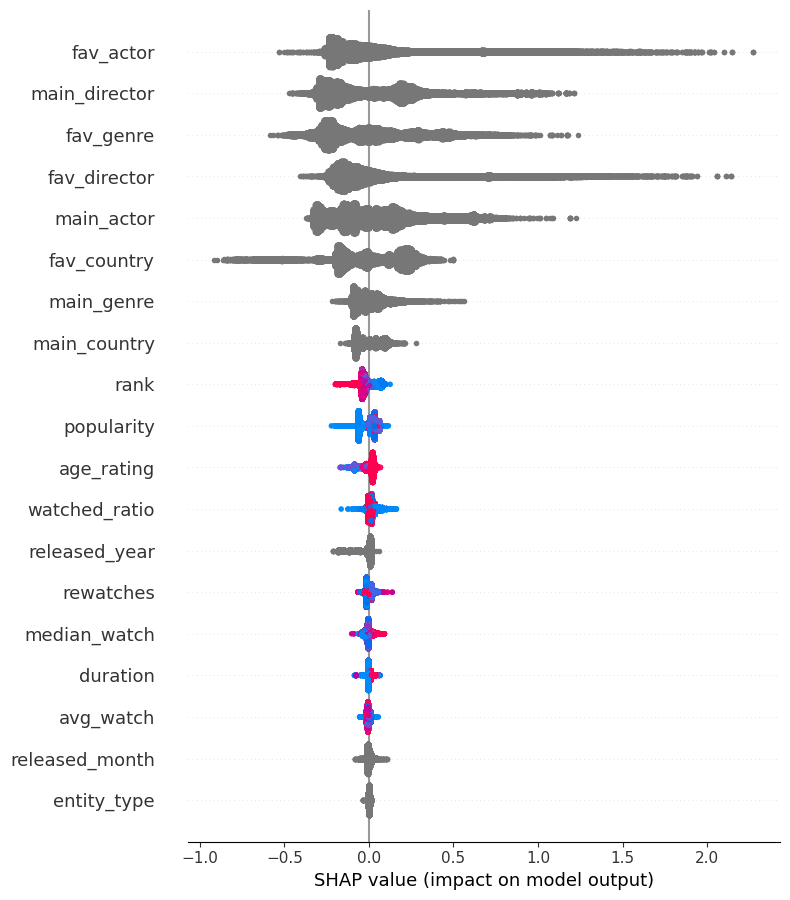

In [650]:
shap.summary_plot(shap_values, X_train, show = False, color_bar = False)

In [651]:
y_test_pred = cbm_classifier.predict_proba(X_test)

print(f"ROC AUC score = {roc_auc_score(y_test, y_test_pred[:, 1]):.2f}")

ROC AUC score = 0.82


Text(0, 0.5, 'True Positive Rate')

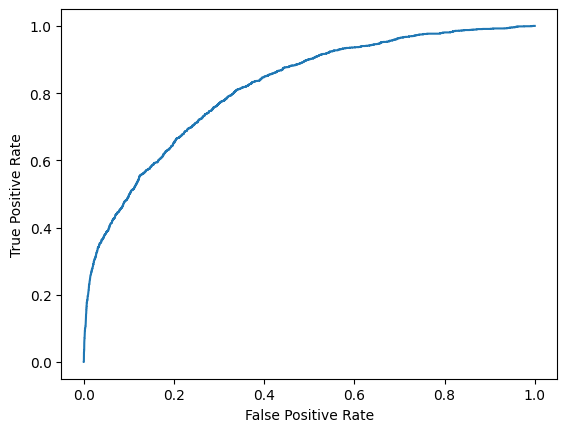

In [652]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred[:, 1])
plt.plot(fpr, tpr);
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [653]:
thresholds[np.where(tpr > 0.8)][0]

0.15592282527750814

In [654]:
cbm_test_set['preds_prob'] = y_test_pred[:, 1]
cbm_test_set['preds'] = cbm_test_set['preds_prob'].apply(lambda x: 1 if x >= 0.2 else 0)

In [655]:
cbm_test_set['preds'].value_counts()

0    7385
1    3557
Name: preds, dtype: int64

In [656]:
rank = cbm_test_set.groupby('user_id')['preds_prob'].apply(lambda x: np.array(x, dtype=float)).values
rank_true = cbm_test_set.groupby('user_id')['target'].apply(lambda x: np.array(x, dtype=int)).values

In [657]:
y_pred = cbm_test_set[cbm_test_set['preds'] == 1].groupby('user_id')['movie_id'].apply(lambda x: np.array(x)).values
y_true = cbm_test_set[cbm_test_set['target'] == 1].groupby('user_id')['movie_id'].apply(lambda x: np.array(x)).values

In [658]:
ap, ndcg = [], []

for i, a in zip(y_true, y_pred):
    ap.append(average_prec_k(i, a))

ndcg = ndcg_score([np.concatenate(rank_true)], [np.concatenate(rank)])

print(f'MAP@10 - {np.mean(ap)}\nNGCD@10 - {ndcg}')

MAP@10 - 0.2426043131739334
NGCD@10 - 0.9263205894575226


#Results
Baseline full data

>MAP@10 - 0.020821731460722744
>
>NGCD@10 - 0.06442144298447545


**LightFM + Ranker on full data**

>MAP@10 - 0.2426043131739334
>
>NGCD@10 - 0.9263205894575226

Baseline good only data

>MAP@10 - 0.07074638571784607
>
>NGCD@10 - 0.05516022242001323


**LightFM + Ranker on good only data**
- LightFM is almost useless in this case

>MAP@10 - 0.25146198830409355
>
>NGCD@10 - 0.8733328092100275